## DBsimilarity - Basics in Chemometrics 

   Computational methods are essential in the field of natural products, particularly for the analysis of unfractionated extracts. Chemoinformatics can provide valuable data for specimen prioritization, biological hypothesis generation, biosynthesis studies, taxonomical studies, and in-silico bioactivity investigations. 
    
   To improve the complex and costly process of drug discovery from natural products, this paper proposes a method that involves (1) converting .sdf files into .csv files, (2) organizing the data into a dataframe, (3) adding chemoinformatics data, (4) constructing a custom database for rapid dereplication of MS data, (5) constructing a candidate list of compounds for rapid dereplication of 2D NMR data, (6) calculating similarities between compounds, and (7) constructing Similarity Networks using Cytoscape. 
    
* The aim of this method is to enable researchers to better understand the information available from a list of compounds found in a specimen. This method does not require specific programming skills and values readability on Jupyter Notebooks to assist users in developing valuable programming skills.


#### Useful sources to learn:
* Pandas: https://pandas.pydata.org/
* RDKit: https://www.rdkit.org/docs/GettingStartedInPython.html
* ChEMBL: https://chembl.gitbook.io/chembl-interface-documentation/web-services
* Mordred: http://mordred-descriptor.github.io/documentation/master/
* Data professor (Chanin Nantasenamat, Ph.D.): https://www.youtube.com/c/DataProfessor
* Pandas from Data professor: https://www.youtube.com/watch?v=9m4n2xVzk9o



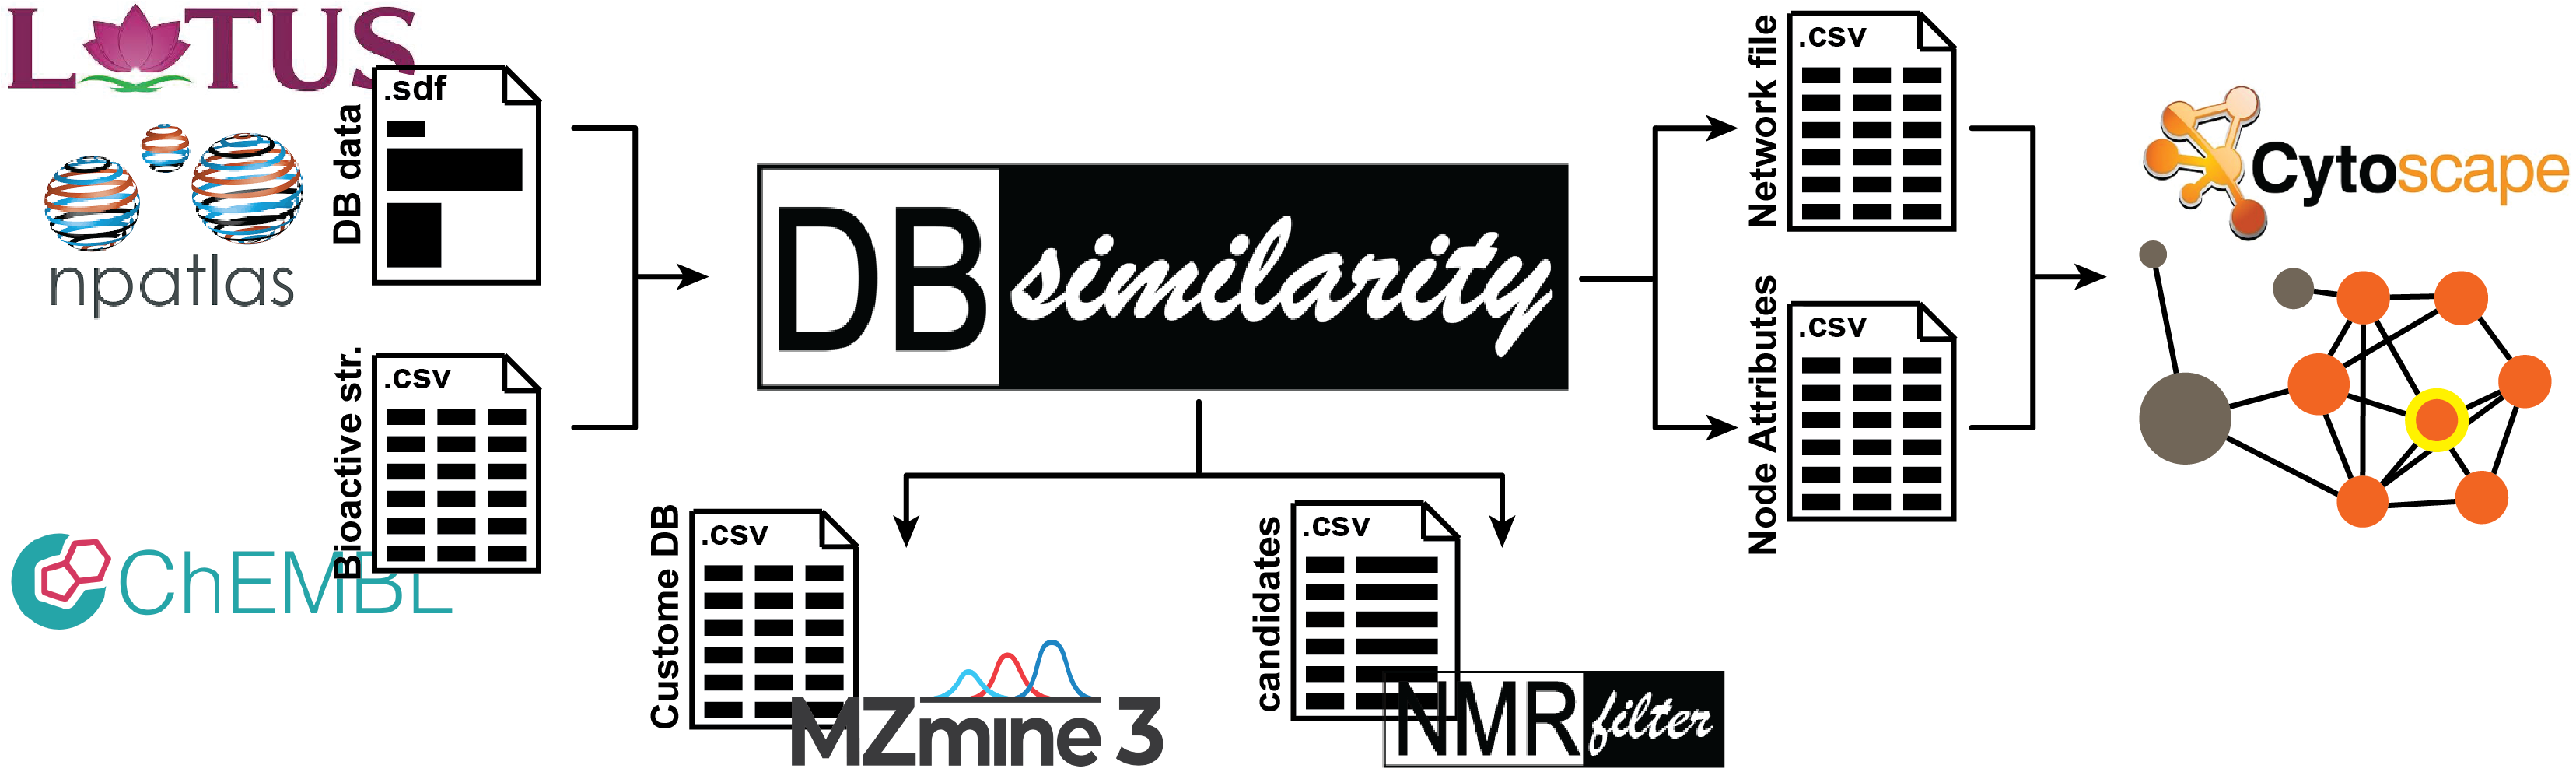

###### Import Required Dependencies

In [1]:
# rdkit (https://www.rdkit.org/docs/Install.html)
import rdkit 
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit.Chem import Descriptors

# chembl websource
from chembl_webresource_client.new_client import new_client

# mordred (http://mordred-descriptor.github.io/documentation/master/)
from mordred import Calculator, descriptors
from mordred import Chi, MoeType

import numpy
import pandas as pd
import seaborn as sns
import plotly
import matplotlib
import networkx as nx
import matplotlib.pyplot as plt
matplotlib.use('nbagg') # allow zoom 
%matplotlib inline
from matplotlib import gridspec
%matplotlib notebook

from wordcloud import WordCloud

import glob
import os
orig_path = os.path.abspath(os.getcwd())

### Select the project which has the data

Each project needs to have its own directory so that the newly created files to be saved inside.

In [2]:
# Get the current working directory
current_directory = %pwd

# Extract the last folder from the path
last_folder = os.path.basename(current_directory)
Project = last_folder

### Reading the input file with data (the database)

Read the input CSV file with the list of structures.

* Users maigth have their costume database with the smile structures (e.g. in-house database of compounds), they can read them directly
* Alternatively, users can download structure databases from well-known sources (e.g. Lotus NP)
    * when using Lotus NP, users may have downloaded the .SDF file. It needs to be converted to CSV (see: )

In [3]:
# Read the list of compounds to test
Target = Project

df_target = pd.read_csv(Target+".csv", sep=";")
m22 = []
for mol in df_target['SMILES']: # for-loop in every row to use the 'smiles' entrees 
    m2 = Chem.MolToInchiKey(Chem.MolFromSmiles(mol)) # produce the INCHIKEY formula
    m22.append(m2) # create a list of INCHIKEY formula 
df_target['InchiKey'] = m22

print(f"List of compounds to be used for this study is now uploaded. It´s size: {df_target.shape}")

List of compounds to be used for this study is now uploaded. It´s size: (183, 8)


In [4]:
df_target.columns

Index(['Unnamed: 0', 'lotus_id', 'SMILES', 'DOI', 'Unordered_taxonomy', 'ID',
       'smiles', 'InchiKey'],
      dtype='object')

##### Indexing compound name from Lotus to this database

* Even though is easier to index rows using simple codes (e.g. Q417362), users will need to refer to the name of the compounds eventually. One way to do it is by filtering the the Lotus database document.


In [5]:
# Download the Lotus database (see: )
df_lotus = pd.read_csv('../../Structure_Similarity_Chemoinformatics-main/Lotus_full/LOTUS_2021_03_simple_extended.csv', sep = ',')

# Create a datafile to use only the selected information (id and smiles)
df_lotus2 = df_lotus.loc[:,["lotus_id","smiles","InchiKey","name"]]

# Combine the database under study with the Lotus reference to keep compound names
df_Name_index = pd.merge(df_target, df_lotus2, on='InchiKey')
df_Name_index2 = df_Name_index.loc[:,["InchiKey","name"]]
df_Name_index2.rename(columns={"name":"name_lotus"},inplace=True)

df_Name_index2.to_csv('Lotus_name_index_annotation.csv', sep=";",index=False)
print(f"A new CSV file was saved for indexing InchiKey structures to compound name according to.")

A new CSV file was saved for indexing InchiKey structures to compound name according to.


###### Filtering compounds from ChEMBL

In [6]:
# Define the list of compound of INTEREST
Filter = "Approved_drugs_small_NP_smiles"
%cd ../../Structure_Similarity_Chemoinformatics-main/CHEMBL
df_ChEMBL = pd.read_csv(Filter+".csv")
os.chdir(current_directory)
print(f"Number of compounds from CHEMBL: {df_ChEMBL.shape}")

/home/nmrbox/rborges/Desktop/GitHub/Structure_Similarity_Chemoinformatics-main/CHEMBL
Number of compounds from CHEMBL: (1414, 5)


In [7]:
# Filter row for empty cells
print(f"Size of the dataframe before filter empty cells: {df_ChEMBL.shape}.")
df_ChEMBL["SMILES"].replace('',numpy.nan,inplace=True)
df_ChEMBL.dropna(subset="SMILES", inplace=True)
# Remove duplicate rows based on the "SMILES" column
df_ChEMBL.drop_duplicates(subset=["SMILES"], inplace=True)
print(f"Size of the dataframe after filter empty and duplicated cells: {df_ChEMBL.shape}.")

m22 = []
for mol in df_ChEMBL['SMILES']: # for-loop in every row to use the 'smiles' entrees 
    m2 = Chem.MolToInchiKey(Chem.MolFromSmiles(mol)) # produce the INCHIKEY formula
    m22.append(m2) # create a list of INCHIKEY formula 
df_ChEMBL['InchiKey'] = m22

df_ChEMBL.to_csv('Approved_drugs_small_NP_smiles.csv', sep=";",index=False)
print(f"A new CSV file was saved for indexing data from Approved_drugs_small_NP_smiles.")

Size of the dataframe before filter empty cells: (1414, 5).
Size of the dataframe after filter empty and duplicated cells: (1414, 5).
A new CSV file was saved for indexing data from Approved_drugs_small_NP_smiles.


### Combine different dataframe

In [8]:
import pandas as pd

def merge_dataframes(df_list, key_column):
    # Merge the dataframes using pivot_table
    merged_df = pd.concat(df_list, axis=0, ignore_index=True)
    merged_df = merged_df.pivot_table(index=key_column, aggfunc='first').reset_index()
    # Create the additional columns
    for i, df in enumerate(df_list):
        col_name = f"additional_column_{i+1}"
        merged_df[col_name] = merged_df[key_column].isin(df[key_column]).astype(int)
    # Fill missing values with 0
    merged_df = merged_df.fillna(0)

    return merged_df

# Combine both dataframes
merged_df = merge_dataframes([df_target,df_ChEMBL], 'InchiKey')
df_Interest = merged_df.loc[merged_df['additional_column_1'] & merged_df['additional_column_2'] == 1]
print(f"Size of the merged structure databases: df_target + df_ChEMBL ({df_target.shape[0]+df_ChEMBL.shape[0]}) = {merged_df.shape[0]}")
print(f"Size of the original structure database to study: {df_target.shape[0]}")
print(f"Size of the ChEMBL structure database used as seed for compounds of interest: {df_ChEMBL.shape[0]}")
print(f"How many compounds can be promptly identified as compounds of interest (co-occurring in both databases): {df_Interest.shape[0]}")

Size of the merged structure databases: df_target + df_ChEMBL (1597) = 1597
Size of the original structure database to study: 183
Size of the ChEMBL structure database used as seed for compounds of interest: 1414
How many compounds can be promptly identified as compounds of interest (co-occurring in both databases): 0


##### Indexing compound name from Lotus to this database

* Even though is easier to index rows using simple codes (e.g. Q417362), users will need to refer to the name of the compounds eventually. One way to do it is by filtering the the Lotus database document.



### Define Compound of Interest

From the list of compounds already defined as compounds of interest (occurring in both databases studied here), list and plot the distribuition of the properties

In [9]:
# Optional. From CSV files already downloaded from CHEMBL
%cd ../../Structure_Similarity_Chemoinformatics-main/CHEMBL
Drug_indication = pd.read_csv("drug_indication_072023_phase2up_smallmolecules.csv", sep=";")
print(f"Number of Drug Indications from CHEMBL: {Drug_indication.shape[0]}")
os.chdir(current_directory)

/home/nmrbox/rborges/Desktop/GitHub/Structure_Similarity_Chemoinformatics-main/CHEMBL
Number of Drug Indications from CHEMBL: 26733


In [10]:
## Drug Indications
#drug_indication = new_client.drug_indication # access the variable new_client

#Drug_indication = pd.DataFrame(drug_indication)
#Drug_indication.to_csv('Drug_indication.csv', sep=";", index=False)

# Merge the DataFrames based on 'molecule_chembl_id' column
Efo_Terms = Drug_indication.merge(df_Interest, on='molecule_chembl_id', how='inner')

Efo_Compounds = Efo_Terms[["molecule_chembl_id","EFO Terms","Parent Molecule Name","Np Likeness Score","Max Phase for Indication","InchiKey"]]
Efo_Compounds.to_csv('Drug_indications_for_coocurring_compounds.csv', sep=";",index=False)
print(f"A new CSV file is saved for the drug indications of those compounds ({df_Interest.shape}) that co-occur in both databases.")

A new CSV file is saved for the drug indications of those compounds ((0, 12)) that co-occur in both databases.


In [11]:
df_Interest

,InchiKey,DOI,SMILES,Unnamed: 0,Unordered_taxonomy,lotus_id,molecule_chembl_id,natural_product,pref_name,smiles,additional_column_1,additional_column_2


<IPython.core.display.Javascript object>


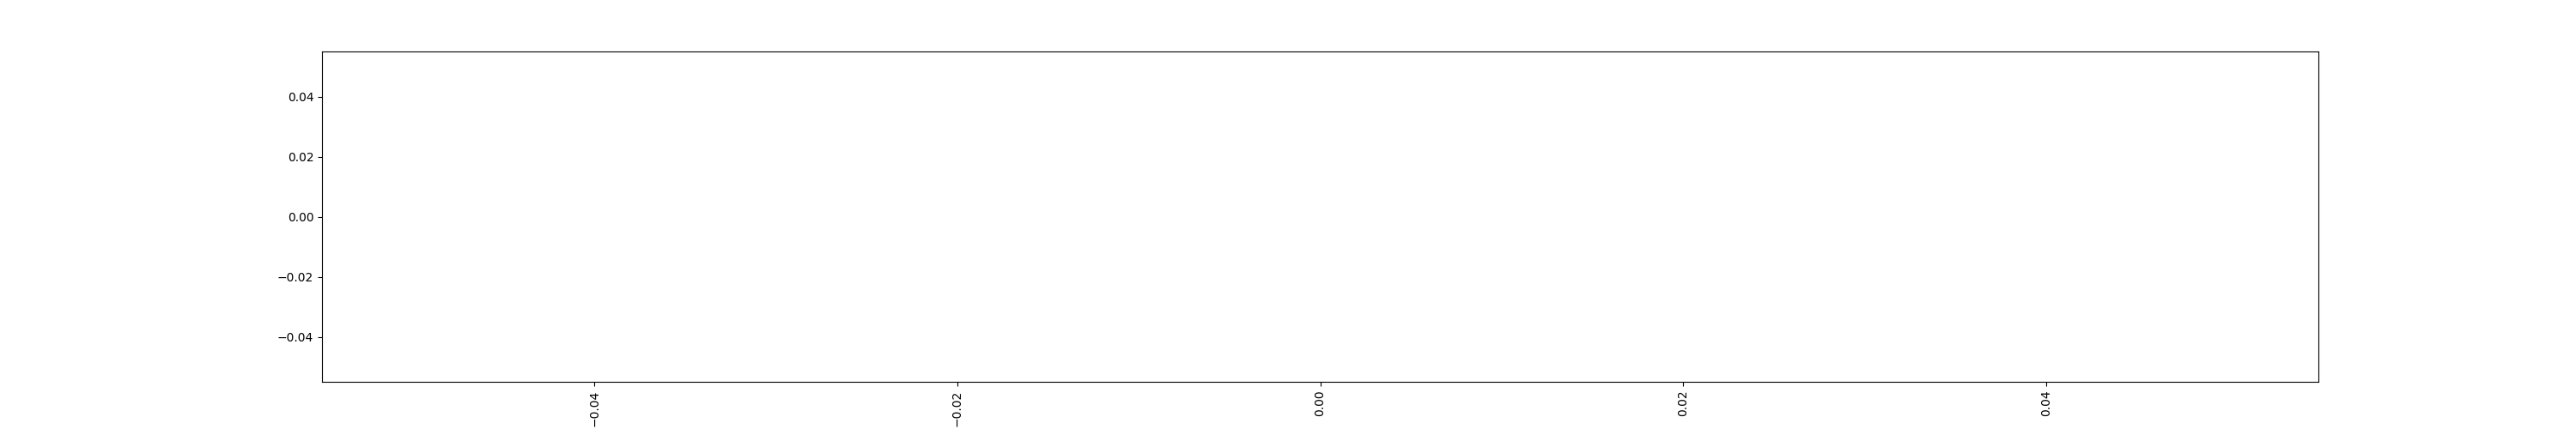

IndexError: index 0 is out of bounds for axis 0 with size 0

In [12]:
# Bar Plot for 'efo_term'
plt.figure(figsize=(30, 5))
Efo_Compounds['EFO Terms'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('EFO Term')
plt.ylabel('Count')
plt.title('Counts of EFO Terms')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# Save the image with high resolution
plt.savefig('BarPLOT_for_EFO_Terms_for_Cooccurring_Drugs.png', dpi=300)
plt.show()

In [ ]:
# Bar Plot for 'pref_name'
plt.figure(figsize=(8, 4))
Efo_Compounds['Parent Molecule Name'].value_counts().plot(kind='bar', color='lightgreen')
plt.xlabel('Pref Name')
plt.ylabel('Count')
plt.title('Counts of Pref Names')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# Save the image with high resolution
plt.savefig('BarPLOT_for_Cooccurring_Drugs.png', dpi=300)
plt.show()

In [ ]:
# Heatmap for 'efo_term' and 'pref_name' co-occurrence
crosstab_df = pd.crosstab(Efo_Compounds['EFO Terms'], Efo_Compounds['Parent Molecule Name'])
plt.figure(figsize=(16,30))
plt.imshow(crosstab_df, cmap='coolwarm', aspect='auto')
plt.xticks(range(len(crosstab_df.columns)), crosstab_df.columns, rotation=45, ha='right')
plt.yticks(range(len(crosstab_df.index)), crosstab_df.index)
plt.xlabel('Pref Name')
plt.ylabel('EFO Term')
plt.title('Co-occurrence Heatmap')
plt.colorbar()
plt.tight_layout()
# Save the image with high resolution
plt.savefig('HeatMAP_for_EFO_Terms_for_Cooccurring_Drugs.png', dpi=300)
plt.show()

<IPython.core.display.Javascript object>


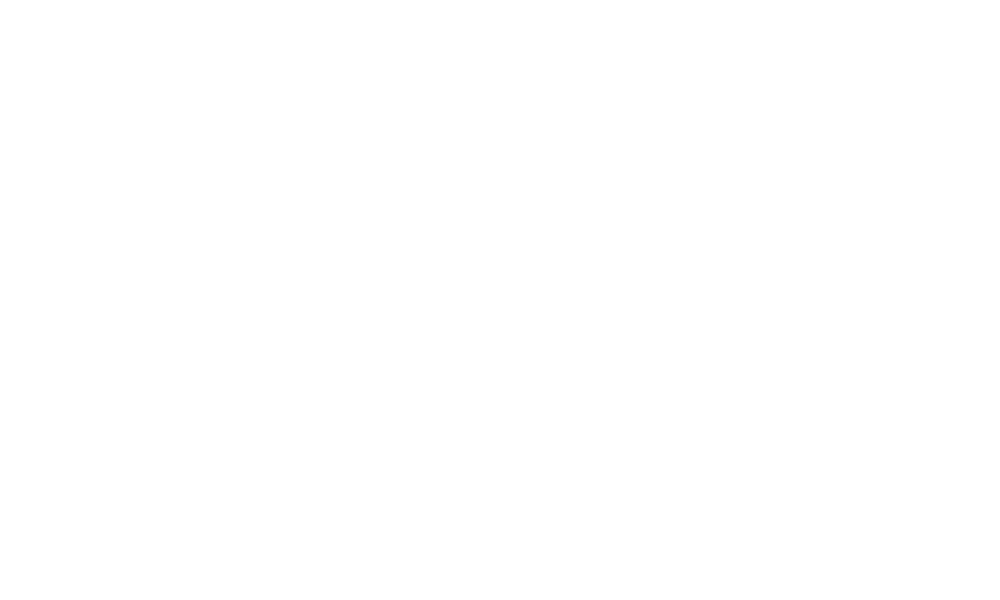

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [13]:
from collections import Counter

# Filter out None values from 'efo_term' column
Efo_Compounds = Efo_Compounds.dropna(subset=['EFO Terms'])

# Count the occurrences of each string in 'efo_terms' column
efo_counts = Counter(Efo_Compounds['EFO Terms'])

# Word Cloud for 'efo_term'
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(efo_counts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for EFO Terms')
# Save the image with high resolution
plt.savefig('Word_Cloud_for_EFO_Terms_for_Cooccurring_Drugs.png', dpi=300)
plt.show()

### Moving forward with DBsimilarity

##### Adding basic chemical information

* In this step, basic chemometric infromation will be added to the dataframe and saved as separate .csv file
    * SlogP (logP is a descriptor closely related to hydrophobicity; positive correlations with retention time on a reverse-phase chromatography)
    * Molecular Formula
    * Molecular Weight
    * Expected m/z values
    * INCHI code structures
    * INCHIKEY structures


In [15]:
# How to get INCHI, INCHIKey, and Exact Mass (molecular weigth) from a series of SMILES
mform = []
mw2 = []
mw_pH2 = []
mw_pNa2 = []
mw_pK2 = []
mw_nH2 = []
m11 = []

for mol in merged_df['SMILES']: # for-loop in every row to use the 'smiles' entrees 
    mform1 =  CalcMolFormula(Chem.MolFromSmiles(mol)) # calculate the exact molecular weigth 
    mform.append(mform1) # create a list of exact molecular weigth 
    
    mw = Descriptors.ExactMolWt(Chem.MolFromSmiles(mol)) # calculate the exact molecular weigth 
    mw2.append(mw) # create a list of exact molecular weigth 
      
    mw_nH = Descriptors.ExactMolWt(Chem.MolFromSmiles(mol)) - 1.007824 # calculate the exact molecular weigth 
    mw_nH2.append(mw_nH) # create a list of exact molecular weigth 
    
    mw_pH = Descriptors.ExactMolWt(Chem.MolFromSmiles(mol)) + 1.007824 # calculate the exact molecular weigth 
    mw_pH2.append(mw_pH) # create a list of exact molecular weigth 
    
    mw_pNa = Descriptors.ExactMolWt(Chem.MolFromSmiles(mol)) + 22.98977 # calculate the exact molecular weigth plus Na
    mw_pNa2.append(mw_pNa) # create a list of exact molecular weigth 
    
    mw_pK = Descriptors.ExactMolWt(Chem.MolFromSmiles(mol)) + 38.96370 # calculate the exact molecular weigth plus K
    mw_pK2.append(mw_pK) # create a list of exact molecular weigth 
    
    m1 = Chem.MolToInchi(Chem.MolFromSmiles(mol)) # produce the INCHI formula
    m11.append(m1) # create a list of INCHI formula
    

    
merged_df['MolFormula'] = mform      # include the newly created lists into the DataFrame
merged_df['Inchi'] = m11
merged_df['MolWeight'] = mw2
merged_df['MolWeight-1H'] = mw_nH2
merged_df['MolWeight+1H'] = mw_pH2
merged_df['MolWeight+Na'] = mw_pNa2
merged_df['MolWeight+K'] = mw_pK2

# save .CSV file with the datafile2 (extended version)
merged_df.to_csv(Project + '_'+ Target +'_extended.csv')

print(f"A new CSV file was saved with all the structures in both databases with additional valuable information, to list: Molecular Formula, Inchi code, Molecular Weight, expected m/z values for [M-H]-, [M+H]+, [M+Na]+, and [M+K]+.")


[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefined stereo

[21:49:52] WARNING: Omitted undefi

[21:49:53] WARNING: Charges were rearranged; Omitted undefined stereo

[21:49:53] WARNING: Omitted undefined stereo

[21:49:53] WARNING: Omitted undefined stereo

[21:49:53] WARNING: Omitted undefined stereo

[21:49:53] WARNING: Omitted undefined stereo

[21:49:53] WARNING: Omitted undefined stereo

[21:49:53] WARNING: Omitted undefined stereo

[21:49:53] WARNING: Charges were rearranged

[21:49:53] WARNING: Charges were rearranged; Omitted undefined stereo

[21:49:53] WARNING: Omitted undefined stereo

[21:49:53] WARNING: Omitted undefined stereo

[21:49:53] WARNING: Omitted undefined stereo

[21:49:53] WARNING: Omitted undefined stereo

[21:49:53] WARNING: Omitted undefined stereo

[21:49:53] WARNING: Omitted undefined stereo

[21:49:53] WARNING: Omitted undefined stereo

[21:49:53] WARNING: Omitted undefined stereo

[21:49:53] WARNING: Omitted undefined stereo

[21:49:53] WARNING: Omitted undefined stereo

[21:49:53] WARNING: Omitted undefined stereo

[21:49:53] WARNING: Omitted und

A new CSV file was saved with all the structures in both databases with additional valuable information, to list: Molecular Formula, Inchi code, Molecular Weight, expected m/z values for [M-H]-, [M+H]+, [M+Na]+, and [M+K]+.


[21:49:54] WARNING: Omitted undefined stereo

[21:49:54] WARNING: Omitted undefined stereo

[21:49:54] WARNING: Omitted undefined stereo

[21:49:54] WARNING: Omitted undefined stereo

[21:49:54] WARNING: Omitted undefined stereo

[21:49:54] WARNING: Omitted undefined stereo

[21:49:54] WARNING: Charges were rearranged

[21:49:54] WARNING: Charges were rearranged; Omitted undefined stereo

[21:49:54] WARNING: Omitted undefined stereo

[21:49:54] WARNING: Omitted undefined stereo

[21:49:54] WARNING: Charges were rearranged; Omitted undefined stereo

[21:49:54] WARNING: Omitted undefined stereo

[21:49:54] WARNING: Omitted undefined stereo

[21:49:54] WARNING: Omitted undefined stereo

[21:49:54] WARNING: Charges were rearranged

[21:49:54] WARNING: Omitted undefined stereo

[21:49:54] WARNING: Omitted undefined stereo

[21:49:54] WARNING: Omitted undefined stereo

[21:49:54] WARNING: Omitted undefined stereo

[21:49:54] WARNING: Charges were rearranged

[21:49:54] WARNING: Omitted undef

##### Get the Classification for the Structures in the database
* Users might want to add NPClassifier or Classyfire information to their visualizations 
    * NPClassifier: the next cell constructs the required file that can be submitted to GNPS for the method NPCLASSIFIER for batch classification
    
    * Classifyre: for that, users must open the *_extended.csv file, copy the column InchiKey and past it at the web server Batch Compound Classification (https://cfb.fiehnlab.ucdavis.edu/)

In [16]:
# Constructing the .csv file to be submitted to NPClassifier 
df_NPclassifier0 = merged_df[["InchiKey","SMILES"]]
df_NPclassifier0.to_csv(Project + '_for_NPClassifier.csv', index = False)

##### Running similarities preparations

In [17]:
%%capture --no-display
# create the column 'Molecules' with the structures for each SMILES entree at the column 'SMILES_parent'
PandasTools.AddMoleculeColumnToFrame(merged_df,'SMILES','Molecule',includeFingerprints=True)
print([str(x) for x in  merged_df.columns])

# Grid visualization of the structures (one can see no more than 50 figures)
#PandasTools.FrameToGridImage(datafile2,column= 'Molecule', molsPerRow=5,subImgSize=(150,150),legendsCol="lotus_id") # visualization only

##### Compare similarity between every pair of structures
    * this can take quite some time

In [18]:
%%capture --no-display
merged_df2 = merged_df

# Function to calculate Morgan fingerprint
def get_morgan_fingerprint(mol):
    return Chem.GetMorganFingerprintAsBitVect(mol, 2)

# Produce a hashed Morgan fingerprint for each molecule
merged_df2['mfp2'] = merged_df2['Molecule'].apply(get_morgan_fingerprint)

# Function to calculate similarity between Morgan fingerprints
def calculate_similarity(fp1, fp2):
    return DataStructs.DiceSimilarity(fp1, fp2)

# One can compare the similarity between every possible pairs of molecules in the list
# This takes time to run
for r in merged_df2.index:
    colname = merged_df.at[r, 'InchiKey']
    merged_df2[colname] = merged_df2['mfp2'].apply(lambda x: calculate_similarity(x, merged_df2.at[r, 'mfp2']))

Mol_ID_values = merged_df2.loc[:,"InchiKey"]
Mol_ID_values # visualization

# The table of similarity. Note the diagonal (=1)
Mol_ID_values_list = Mol_ID_values.tolist()
simTable = merged_df2[[*Mol_ID_values_list]] # simTable
simTable2 = simTable.iloc[:(len(Mol_ID_values_list))]
simTable2.head(2)

print(f"SimTablet2 is the square matrix (with a diagonal = 1, {simTable2.shape}) with all the similarities calculated between every pair of structures.")

##### Calculate the correlation matrix and reshape into 3 columns

In [19]:
Corr_Threshold = 0.85

# calculate the correlation matrix and reshape into 3 columns
simTable2_corr = simTable2.corr().stack().reset_index()

# rename the column headers
simTable2_corr.columns = ['SOURCE', 'TARGET', 'CORRELATION']

# create a mask to identify rows with duplicate features
mask_dups = (simTable2_corr[['SOURCE', 'TARGET']].apply(frozenset, axis=1).duplicated()) | (simTable2_corr['SOURCE']==simTable2_corr['TARGET']) 

# apply the mask to clean the correlation dataframe
simTable2_corr2 = simTable2_corr[~mask_dups]
simTable2_corr2

# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=simTable2_corr2.loc[ (simTable2_corr2['CORRELATION'] > Corr_Threshold) & (simTable2_corr2['SOURCE'] != simTable2_corr2['TARGET']) ]
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'SOURCE', 'TARGET')
nx.from_pandas_edgelist(links_filtered, 'SOURCE', 'TARGET')
links_filtered.head(3)

# Plot the network:
#nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

# save .CSV file (3 columns file) with the network for e.g. Cytoscape
links_filtered.to_csv(Project + '_DB_compounds_Similarity_'+ str(Corr_Threshold) +'.csv', sep=";", index=False)
print(f"Done! Now that we have saved the similarity table as a 'Source', 'Target', and 'Interaction' (3 column) table with {len(Mol_ID_values.index)} rows.")

Done! Now that we have saved the similarity table as a 'Source', 'Target', and 'Interaction' (3 column) table with 1597 rows.


In [20]:
print(f"Note the size of the square matrix {simTable2.shape} and the size of the Similarity Network matrix {simTable2_corr2.shape}.")


Note the size of the square matrix (1597, 1597) and the size of the Similarity Network matrix (1274406, 3).


<div>
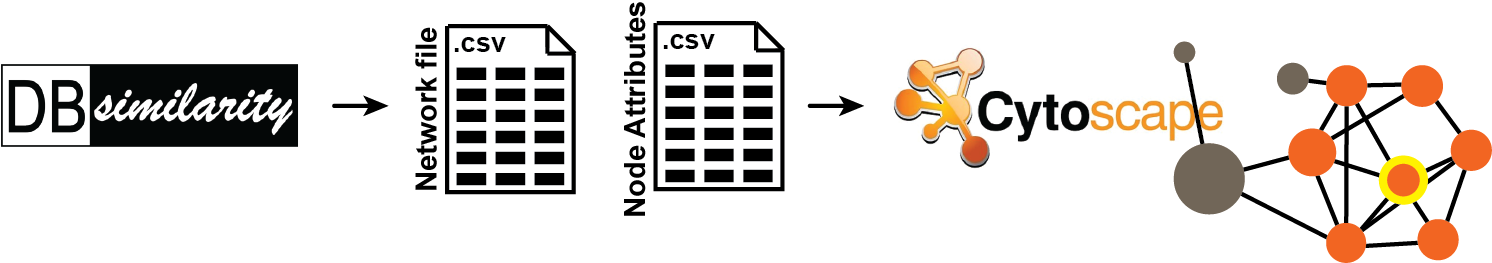
</div>

In [21]:
# Filter links_filtered based on the 'InchiKey' column in df_target
filtered_links_Target = links_filtered[links_filtered['SOURCE'].isin(df_target['InchiKey']) |
                                links_filtered['TARGET'].isin(df_target['InchiKey'])]

# save .CSV file (3 columns file) with the network for e.g. Cytoscape
filtered_links_Target.to_csv(Project + '_filtered_links_Target_'+ str(Corr_Threshold) +'.csv', sep=";", index=False)
print(f"Done! Now that we have saved the similarity table with compounds that are present in the {Project} database.")

print(simTable2_corr2.shape)
print(simTable2.shape)
print(filtered_links_Target.shape)

Done! Now that we have saved the similarity table with compounds that are present in the Actaea_racemosa database.
(1274406, 3)
(1597, 1597)
(6595, 3)


In [22]:
## Drug Indications
#drug_indication = new_client.drug_indication # access the variable new_client

#Drug_indication = pd.DataFrame(drug_indication)
#Drug_indication.head(2)

compounds_similar_source = df_ChEMBL.merge(filtered_links_Target,left_on='InchiKey',right_on='SOURCE',how='inner')

# Merge with 'TARGET' column from filtered_links_Target
compounds_similar_target = df_ChEMBL.merge(filtered_links_Target,left_on='InchiKey',right_on='TARGET',how='inner')
# Concatenate the two DataFrames
Compounds_similar = pd.concat([compounds_similar_source, compounds_similar_target], ignore_index=True)
# Drop the redundant 'SOURCE' and 'TARGET' columns
Compounds_similar = Compounds_similar.drop(columns=['SOURCE', 'TARGET', 'CORRELATION'])
# Filter and delete rows with repeating 'molecule_chembl_id'
Compounds_similar = Compounds_similar[~Compounds_similar['molecule_chembl_id'].duplicated()]

print(f"Number of compounds similar to those in TARGET {Compounds_similar.shape}")

# Merge the DataFrames based on 'molecule_chembl_id' column
Efo_Terms = Drug_indication.merge(Compounds_similar, on='molecule_chembl_id', how='inner')
print(Efo_Terms.shape)
Efo_Terms.head(1)

Efo_Compounds = Efo_Terms[["EFO Terms","Parent Molecule Name"]]
Efo_Compounds.to_csv(Project + '_Efo_Compounds.csv', sep=";", index=False)
print(f"Done! Now that we have saved the Efo Term Compounds table with compounds that are similar to the expected compounds.")


Number of compounds similar to those in TARGET (8, 6)
(120, 21)
Done! Now that we have saved the Efo Term Compounds table with compounds that are similar to the expected compounds.


In [ ]:
# Bar Plot for 'efo_term'
plt.figure(figsize=(14, 6))
Efo_Compounds['EFO Terms'].value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('EFO Term')
plt.ylabel('Count')
plt.title('Counts of EFO Terms')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Bar Plot for 'pref_name'
plt.figure(figsize=(14, 6))
Efo_Compounds['Parent Molecule Name'].value_counts().plot(kind='bar', color='lightgreen')
plt.xlabel('Pref Name')
plt.ylabel('Count')
plt.title('Counts of Pref Names')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Heatmap for 'efo_term' and 'pref_name' co-occurrence
crosstab_df = pd.crosstab(Efo_Compounds['EFO Terms'], Efo_Compounds['Parent Molecule Name'])
plt.figure(figsize=(16, 38))
plt.imshow(crosstab_df, cmap='coolwarm', aspect='auto')
plt.xticks(range(len(crosstab_df.columns)), crosstab_df.columns, rotation=45, ha='right')
plt.yticks(range(len(crosstab_df.index)), crosstab_df.index)
plt.xlabel('Pref Name')
plt.ylabel('EFO Term')
plt.title('Co-occurrence Heatmap')
plt.colorbar()
plt.tight_layout()
# Save the image with high resolution
plt.savefig('HeatMAP_for_EFO_Terms_for_SIMILAR_Drugs.png', dpi=300)
plt.show()

<IPython.core.display.Javascript object>


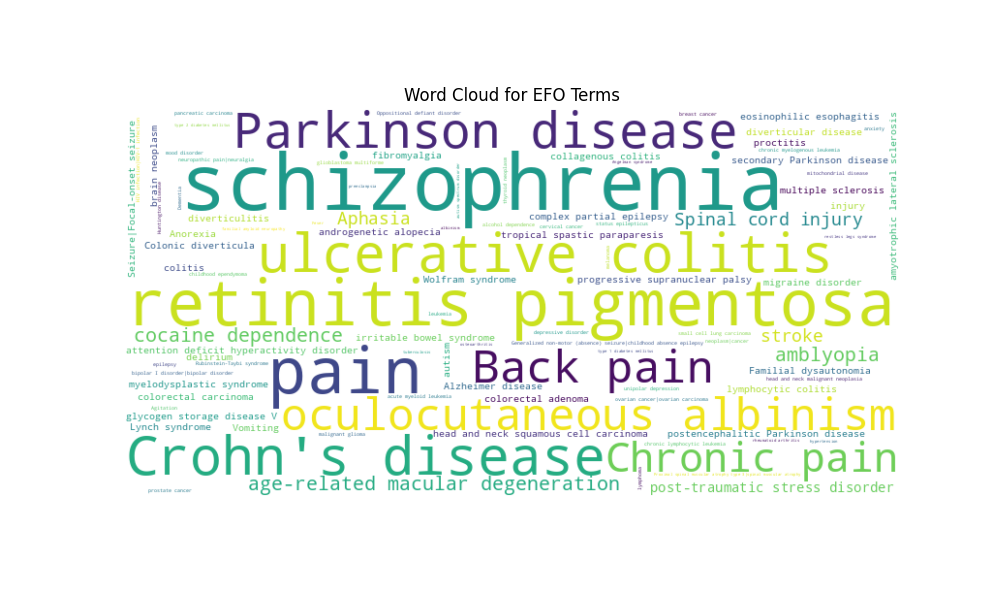

In [23]:
from collections import Counter

# Filter out None values from 'efo_term' column
Efo_Compounds = Efo_Compounds.dropna(subset=['EFO Terms'])

# Count the occurrences of each string in 'efo_terms' column
efo_counts = Counter(Efo_Compounds['EFO Terms'])

# Word Cloud for 'efo_term'
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(efo_counts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for EFO Terms')
# Save the image with high resolution
plt.savefig('Word_Cloud_for_EFO_Terms_for_SIMILAR_Drugs.png', dpi=300)
plt.show()

In [ ]:
# Filter and keep only rows with "Search EFO TERM" in the 'efo_term' column

Efo_Term = "cardiovascular"

# Filter out None values from 'efo_term' column
Efo_Compounds = Efo_Compounds.dropna(subset=['EFO Terms'])
Efo_Compounds2 = Efo_Compounds[Efo_Compounds['EFO Terms'].str.contains(Efo_Term, case=False)]

# Stacked Bar Plot: Drug Frequency by Type of Diabetes
df_pivot = Efo_Compounds2.pivot_table(index='Parent Molecule Name', columns='EFO Terms', aggfunc='size', fill_value=0)
df_pivot.plot(kind='bar', stacked=True)
plt.title(f"Drug Frequency by Type of {Efo_Term}")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Type of Diabetes')
plt.tight_layout()
# Save the image with high resolution
plt.savefig(f"multiBarplot_for_EFO_Terms_{Efo_Term}_for_SIMILAR_Drugs.png", dpi=300)
plt.show()

# Heatmap: Drug-Condition Association
plt.figure(figsize=(8, 10))
df_heatmap = Efo_Compounds2.pivot_table(index='Parent Molecule Name', 
                                        columns='EFO Terms', 
                                        aggfunc='size', 
                                        fill_value=0)
sns.heatmap(df_heatmap, 
            cmap='Blues', 
            annot=True, 
            fmt='d')
plt.title(f"Drug-Condition Association to {Efo_Term}")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# Save the image with high resolution
plt.savefig(f"HeatMAP_for_EFO_Terms_{Efo_Term}_for_SIMILAR_Drugs.png", dpi=300)
plt.show()
plt.show()

Thank you for using.

Feel free to contact us at ricardo_mborges@ufrj.br for doubts, ideas for next projects, or for collaborations. 

Check also:
* NMRfilter: Applying NMR compound identification using NMRfilter to match predicted to experimental data
    * https://link.springer.com/article/10.1007/s11306-020-01748-1
    

* DAFdiscovery: Data Fusion-based Discovery (DAFdiscovery) pipeline to aid compound annotation and bioactive compound discovery across diverse spectral data 
    * https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/abs/10.1002/pca.3178
